In [1]:
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

# Définitions

Nous allons commencer par quelques définitions :

**Définition 1 :** Une image (en nuances de gris) $M_{xy}$ est une matrice de $M_{n, p}(R)$.

(-0.5, 549.5, 551.5, -0.5)

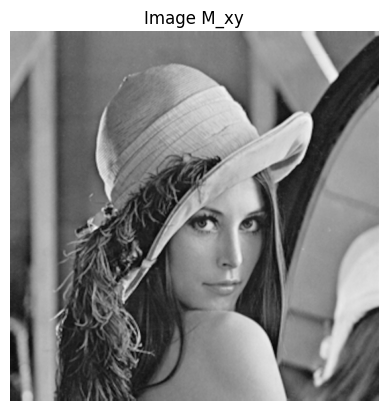

In [2]:
M_xy = np.array(Image.open("../data/lena.png").convert("L"))
plt.figure()
plt.imshow(M_xy, cmap="gray")
plt.title("Image M_xy")
plt.axis("off")

In [3]:
print("Dimension de l'image :", M_xy.shape)

Dimension de l'image : (552, 550)


**Définition 2 :** Le gradient d'une image $M_{xy}$ est une matrice $G_{xy}$ de $M_{n, p}(R)$ telle que :

$$G_{xy} = \begin{pmatrix} G_x \\ G_y \end{pmatrix} = \begin{pmatrix} \frac{\partial M_{xy}}{\partial x} \\ \frac{\partial M_{xy}}{\partial y} \end{pmatrix}$$

Le gradient définit *la direction* de **la plus forte variation de l'intensité lumineuse dans l'image**.

**Définition 3** : Le module du gradient d'une image $M_{xy}$ est un scalaire $f_{xy}$ défini par :

$$f_{xy} = \sqrt{G_x^2 + G_y^2}$$

Le module du gradient définit *l'intensité* de **la plus forte variation de l'intensité lumineuse dans l'image**.

# Méthodologie de la détection de contours

A partir de ces définitions, nous pouvons définir un contour comme étant **la frontière entre deux régions d'intensité lumineuse différentes**. 

Ainsi, pour détecter les contours d'une image, il faut détecter les points où l'intensité lumineuse varie le plus. Pour cela, il faut déterminer les points où le module du gradient est maximal.

Malheureusement, le gradient d'une image n'est pas calculable explicitement. Nous utiliserons donc des approximations du gradient à partir de **matrices de convolution**.

[Eventuellement à faire : justifier en quoi les matrices de convolution sont des approximations du gradient]

**Définition 4 :** Soit $M_{xy}$ une image et $K$ une matrice de convolution. On appelle convolution de $M_{xy}$ par $K$ l'image $M'_{xy}$ définie par :

$$M'_{xy} = \sum_{i=0}^{n-1} \sum_{j=0}^{m-1} K_{ij} M_{x+i,y+j}$$

In [4]:
def convolution(M, K):
    # Get dimensions of the input image and the kernel
    m, n = M.shape
    k, l = K.shape

    # Initialize the result matrix
    result = np.zeros((m, n))

    # Perform convolution
    for i in range(m):
        for j in range(n):
            # Iterate over the kernel
            for x in range(k):
                for y in range(l):
                    # Check bounds to avoid indexing errors
                    if 0 <= i + x < m and 0 <= j + y < n:
                        result[i, j] += K[x, y] * M[i + x, j + y]

    return result

La littérature a identifié plusieurs matrices de convolution permettant d'approximer le gradient d'une image. Nous allons étudier les matrices dites de Sobel.

**Définition 5 :** On appelle matrices de Sobel les matrices de convolution $S_x$ et $S_y$ définies par :

$$S_x = \begin{pmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{pmatrix} \quad \text{et} \quad S_y = \begin{pmatrix} -1 & -2 & -1 \\ 0 & 0 & 0 \\ 1 & 2 & 1 \end{pmatrix}$$

In [5]:
Sx = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
Sy = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
print(f"Sx = {Sx}\n")
print(f"Sy = {Sy}")

Sx = [[ 1  0 -1]
 [ 2  0 -2]
 [ 1  0 -1]]

Sy = [[-1 -2 -1]
 [ 0  0  0]
 [ 1  2  1]]


L'image $M'_{xy}$ obtenue par convolution de $M_{xy}$ par $S_x$ (resp. $S_y$) est appelée image de Sobel horizontale (resp. verticale).

Ainsi, le gradient d'une image $M_{xy}$ peut être approximé par :

$$G_{xy} \approx \begin{pmatrix} M'_{xy} \\ M'_{xy} \end{pmatrix} = \begin{pmatrix} S_x \ast M_{xy} \\ S_y \ast M_{xy} \end{pmatrix}$$

où $\ast$ désigne l'opération de convolution.

In [6]:
Gx = convolution(M_xy, Sx)
Gy = convolution(M_xy, Sy)

On peut ainsi calculer le module de $G_{xy}$ :

In [7]:
module_Gxy = np.sqrt(Gx**2 + Gy**2)

(-0.5, 549.5, 551.5, -0.5)

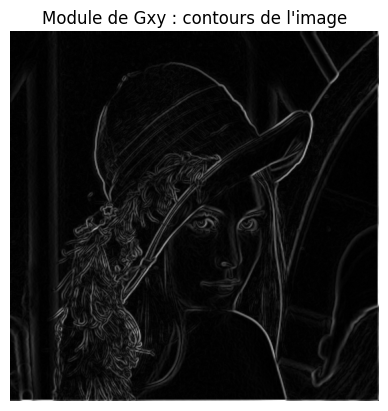

In [8]:
plt.figure()
plt.imshow(module_Gxy, cmap="gray")
plt.title("Module de Gxy : contours de l'image")
plt.axis("off")

# Seuil

Pour paramétrer la sensibilité du filtre, on peut utiliser un seuil $s$. Les pixels dont le module du gradient est supérieur à $s$ sont considérés comme appartenant au contour.

(Donc, plus $s$ est grand, plus le filtre est sensible.)

On peut tester plusieurs valeurs de $s$ pour trouver celle qui convient le mieux :

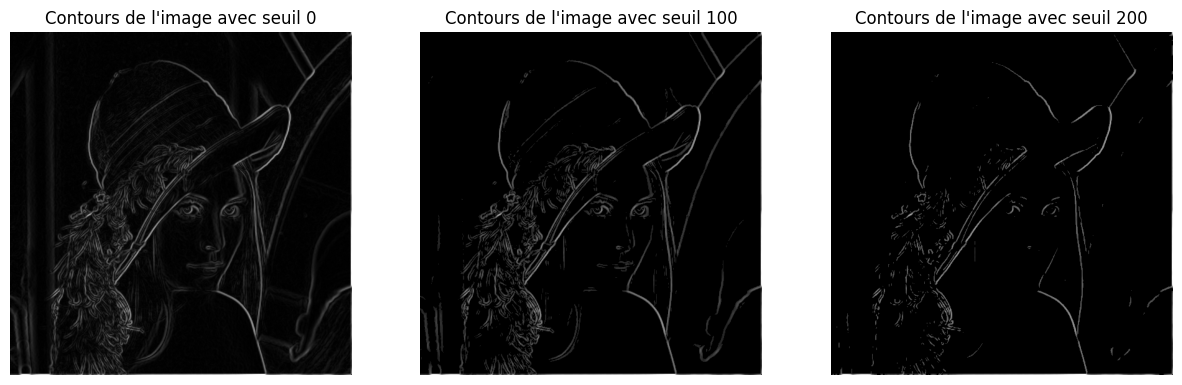

In [9]:
plt.subplots(1, 3, figsize=(15, 5))

for i, threshold in enumerate([0, 100, 200]):
    filtered_image = module_Gxy.copy()
    filtered_image[filtered_image < threshold] = 0
    
    plt.subplot(1, 3, i+1)
    plt.imshow(filtered_image, cmap="gray")
    plt.title(f"Contours de l'image avec seuil {threshold}")
    plt.axis("off")

Une autre méthode pour déterminer le filtre est de calculer l'histogramme des valeurs du module du gradient. 

On peut ensuite choisir un seuil $s$ tel que la valeur du module du gradient soit supérieure à $s$ pour un certain pourcentage de pixels (un quantile), par exemple 80%.

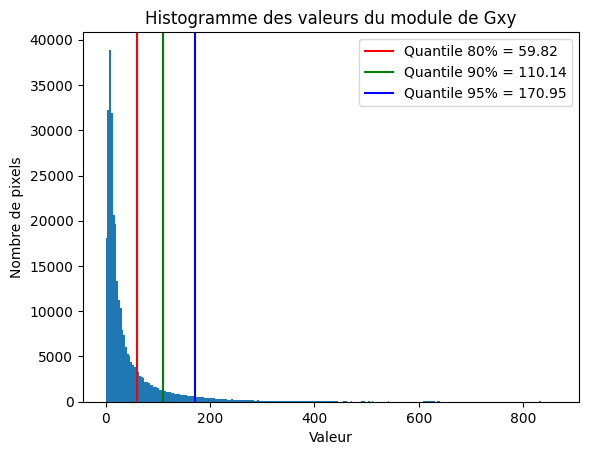

In [10]:
quantiles = {q:np.quantile(module_Gxy, q) for q in [0.80, 0.9, 0.95]}

plt.figure()
plt.hist(module_Gxy.ravel(), bins=256)
plt.title("Histogramme des valeurs du module de Gxy")
plt.xlabel("Valeur")
plt.ylabel("Nombre de pixels")

plt.axvline(quantiles[0.8], color='red')
plt.axvline(quantiles[0.9], color='green')
plt.axvline(quantiles[0.95], color='blue')
plt.legend([f"Quantile {key*100:.0f}% = {value:.2f}" for key, value in quantiles.items()])


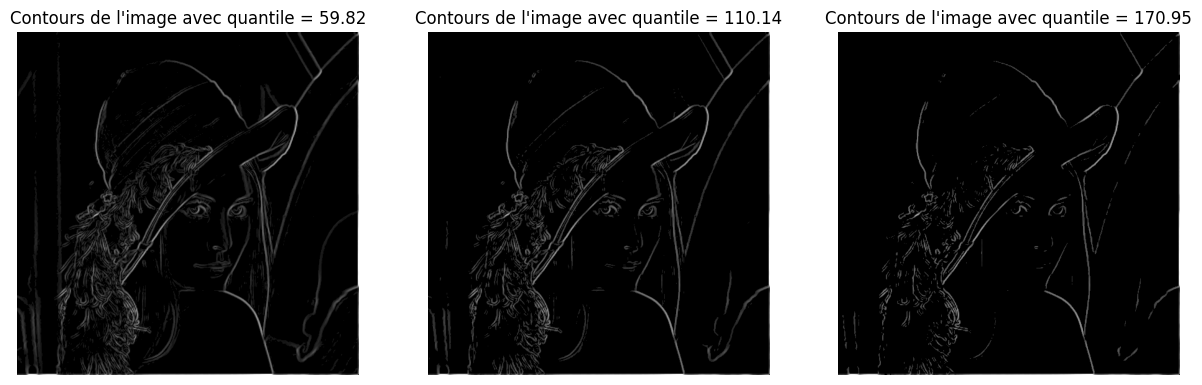

In [11]:
plt.subplots(1, 3, figsize=(15, 5))

for i, quantile in enumerate(quantiles.values()):
    filtered_image = module_Gxy.copy()
    filtered_image[filtered_image < quantile] = 0
    
    plt.subplot(1, 3, i+1)
    plt.imshow(filtered_image, cmap="gray")
    plt.title(f"Contours de l'image avec quantile = {quantile:.2f}")
    plt.axis("off")

# Traitement du bruit

Certaines images peuvent être bruitées :

(-0.5, 256.5, 256.5, -0.5)

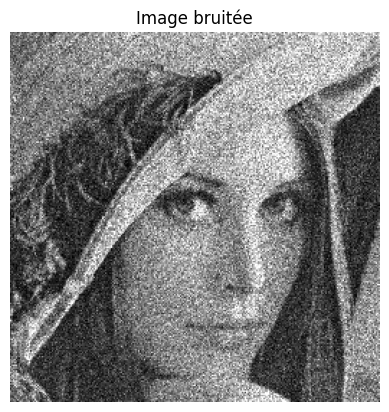

In [33]:
noised_lena = np.array(Image.open("../data/noised_lena.png").convert("L"))
plt.imshow(noised_lena, cmap="gray")
plt.title("Image bruitée")
plt.axis("off")

Le filtre de Sobel ne fonctionnent pas correctement sur de telles images :

(-0.5, 256.5, 256.5, -0.5)

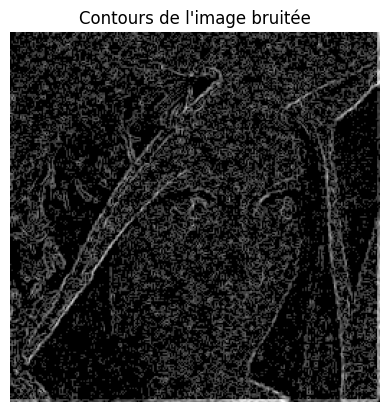

In [42]:
noised_lena_gx = convolution(noised_lena, Sx)
noised_lena_gy = convolution(noised_lena, Sy)

noised_lena_module = np.sqrt(noised_lena_gx**2 + noised_lena_gy**2)

noised_lena_module[noised_lena_module < quantiles[0.95]] = 0

plt.figure()
plt.imshow(noised_lena_module, cmap="gray")
plt.title("Contours de l'image bruitée")
plt.axis("off")

Pour résoudre ce problème, on peut utiliser un autre filtre à matrice de convolution pour réduire le bruit. 

Par exemple, le filtre gaussien défini par : 

$$G = \frac{1}{16} \begin{pmatrix} 1 & 2 & 1 \\ 2 & 4 & 2 \\ 1 & 2 & 1 \end{pmatrix}$$

(-0.5, 256.5, 256.5, -0.5)

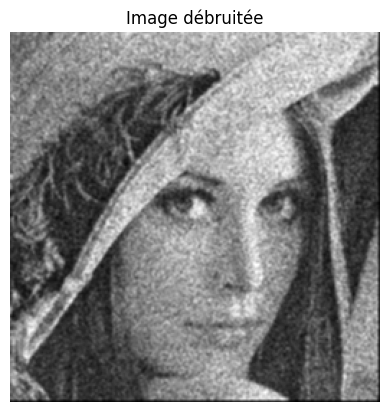

In [35]:
gaussian_filter = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) / 16

denoised_lena = convolution(noised_lena, gaussian_filter)

plt.figure()
plt.imshow(denoised_lena, cmap="gray")
plt.title("Image débruitée")
plt.axis("off")

(-0.5, 256.5, 256.5, -0.5)

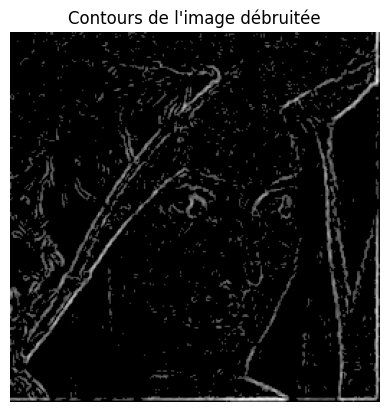

In [40]:
denoised_lena_gx = convolution(denoised_lena, Sx)
denoised_lena_gy = convolution(denoised_lena, Sy)

denoised_lena_module = np.sqrt(denoised_lena_gx**2 + denoised_lena_gy**2)

denoised_lena_module[denoised_lena_module < quantiles[0.95]] = 0

plt.figure()
plt.imshow(denoised_lena_module, cmap="gray")
plt.title("Contours de l'image débruitée")
plt.axis("off")